# 1. Dataset Description
- This dataset, collected by data scientists at BigMart is the 2013 sales data for 1559 products across 10 stores in different cities.
- Number of tuples: 8523

## 1.1 Different features in the dataset:
- Item_Identifier: Unique product ID
- Item_Weight: Weight of product
- Item_Fat_Content: Whether the product is low fat or not
- Item_Visibility: The % of the total display area of all products in a store allocated to the particular product
- Item_Type: The category to which the product belongs
- Item_MRP: Maximum Retail Price (list price) of the product
- Outlet_Identifier: Unique store ID
- Outlet_Establishment_Year: The year in which the store was established
- Outlet_Size: The size of the store in terms of ground area covered
- Outlet_Location_Type: The type of city in which the store is located
- *Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket
- Item_Outlet_Sales: sales of the product in the particular store. This is the outcome variable to be predicted.


# 2. Packages and Data

Installing Optuna, which is not available in Colab by default.

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00


Importing all the necessary packages

In [75]:
# For linear algebra
import numpy as np
# For data processing
import pandas as pd
import math
from matplotlib import pyplot as plt
import seaborn as sns

# imputes missing values by predicting the missing values using K-nearest neighbour appraoch
from sklearn.impute import KNNImputer

# Label Encoder encodes categorical values to numerical labels. Example, {"cat", "dog"} -> {1, 2};
# PolynomialeFeatures is used to generate polynomial features from input data. Used to model non-linear relationships in Linear Regression.
# StandardScalar is used to normalize data. i.e to normalize all different types of features to the same scale.
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler

# Used to combine data processing and model training to a single workflow.
from sklearn.pipeline import Pipeline

# ElasticNet is used to regularize Linear model to avoid overfitting data or irrelavant features.
# Lasso shrinks less important features to zero for simpler model.
# Reduces the impact of large irrelavant coefficients. i.e. Avoids model from being sensitive to outliers.
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from xgboost import XGBRegressor

# Tunes Hyperparameters automatically
import optuna

# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

import pickle

# set seed for reproductibility
np.random.seed(42)

Mounting Google drive. And, loading the dataset.

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
DRIVE_FOLDER_LOCATION = '/content/drive/MyDrive/sales-prediction'

In [78]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  import os
  if os.path.isdir(DRIVE_FOLDER_LOCATION) == False:
    os.makedirs(DRIVE_FOLDER_LOCATION)
    print("Directory" + DRIVE_FOLDER_LOCATION + " did not exist but was created.")

    os.chdir(DRIVE_FOLDER_LOCATION)
    print("Working directory changed to: " + DRIVE_FOLDER_LOCATION)



In [79]:
train = pd.read_csv(DRIVE_FOLDER_LOCATION + "/train.csv")

## Exploring the Dataset

In [80]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [81]:
train.shape

(8523, 12)

Here, we can see that our dataset has 8523 tuples with 12 features.

Checking Datatypes of each features

In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Item Identifier is a unique id of each item. So, this is not a relevant data so, we will drop it later.
Now, we will analyze the summary of statistics (min, max, mean, etc..) for all of our columns.

In [83]:
train.describe(include="all")

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,7060.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,6113,8523,8523,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDW13,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,2793,3350,5577,NaN
mean,NaN,12.857645,NaN,0.066132,NaN,140.992782,NaN,1997.831867,NaN,NaN,NaN,2181.288914
std,NaN,4.643456,NaN,0.051598,NaN,62.275067,NaN,8.371760,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.773750,NaN,0.026989,NaN,93.826500,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.053931,NaN,143.012800,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.850000,NaN,0.094585,NaN,185.643700,NaN,2004.000000,NaN,NaN,NaN,3101.296400


In [84]:
# Now, getting the number of missing datapoints per column
train.isnull().sum().sort_values(ascending=False)

,0
Outlet_Size,2410
Item_Weight,1463
Item_Identifier,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Location_Type,0


Here, we can see that the column Outlet_Size has 2410 missing values.

And, Item_Weight has 1463 missing values.

Now, we have to either drop all of them or we can do some analysis and fill the missing values. Dropping 2410 i.e. 28% of out total data items is not a good idea.

In [85]:
train.Outlet_Establishment_Year

,Outlet_Establishment_Year
0,1999
1,2009
2,1999
3,1998
4,1987
...,...
8518,1987
8519,2002
8520,2004
8521,2009


The oldest outlet was established in 1985 and the newest in 2009.
So, We could convert this column into a categorical variable by grouping the outlets into categories based on their establishment years, such as 1985-1990, 1991-2000, and so on.

# 3. Exploratory Data Analysis (EDA)

First, we will split the dataset into training and testing subset

In [86]:
train_subset, test_subset = train_test_split(train, test_size=0.2, random_state=42)

## 3.1 Univariate Analysis

### 3.1.1 Numeric Features

In [87]:
numeric_columns = train_subset.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [88]:
numeric_columns

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [90]:
train_subset.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,5644.0,12.886347,4.644777,4.555,8.880000,12.600000,16.850000,21.350000
Item_Visibility,6818.0,0.066097,0.051429,0.000,0.026939,0.054129,0.094791,0.328391
Item_MRP,6818.0,141.905134,62.547789,31.290,94.175200,144.262800,186.855600,266.888400
Outlet_Establishment_Year,6818.0,1997.856850,8.395692,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,6818.0,2202.365231,1720.024464,33.290,851.225300,1808.312800,3123.933600,13086.964800


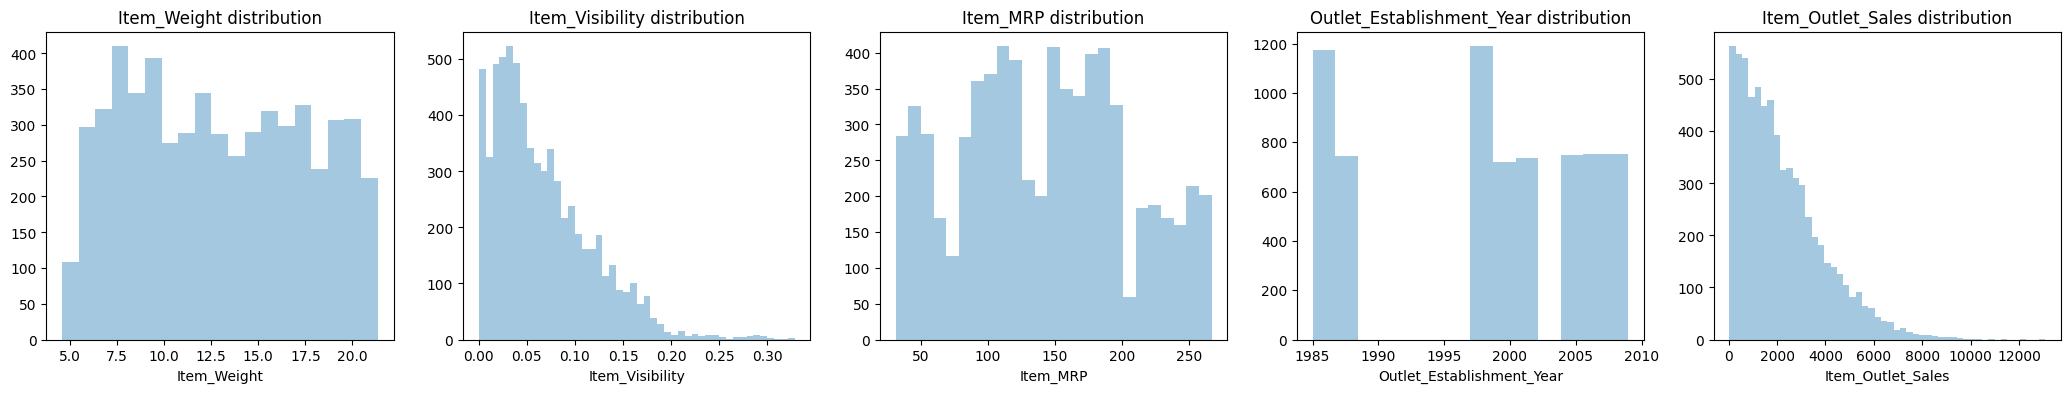

In [91]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numeric_columns):
    sns.distplot(train_subset[col], kde=False, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

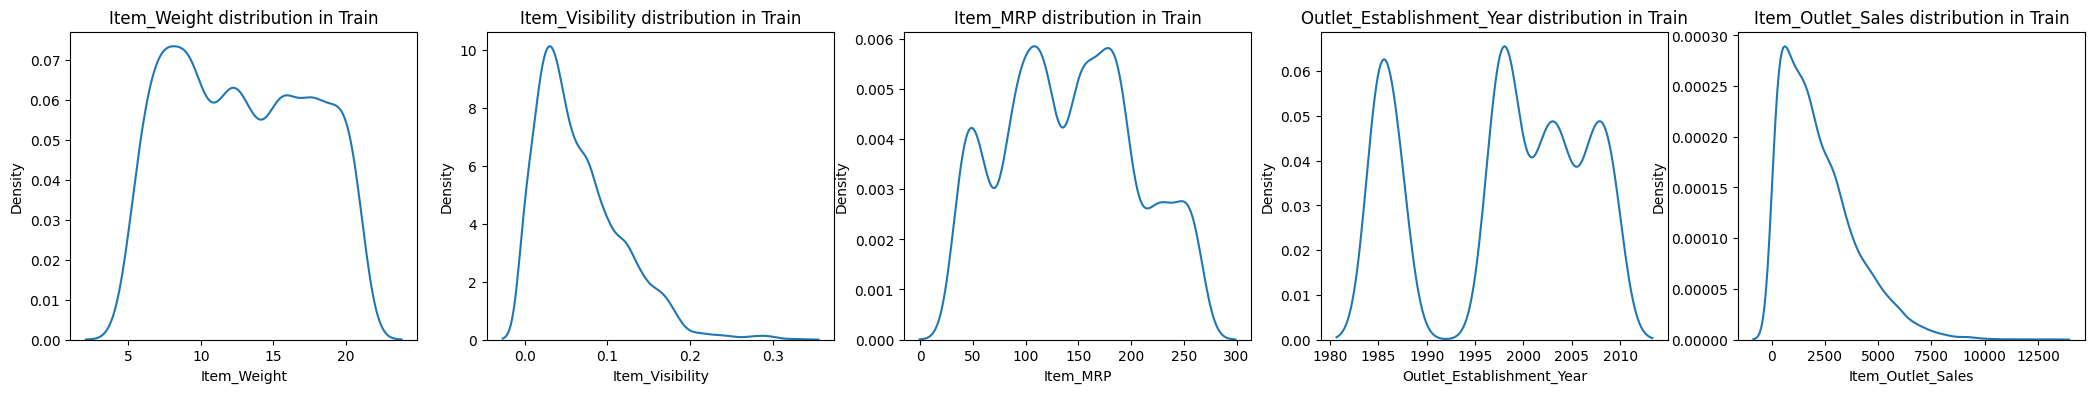

In [93]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numeric_columns):
    sns.kdeplot(data=train_subset, x=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Train')

Observations:
- Item weight ranges from 5 Kg to 20 Kg.
- Item visibility is right skewed.
- There are more products in the range of 100 MRP - 180 MRP in the Item_MRP feature
- Lots of stores have been established in the years 1985, 1998 etc... and there was no store establishment between 1990 and 1995.
- Item_Outlet_Sales feature is right skewed. We can may be try to do a transformation in order to obtain a normal ou Gaussian distribution

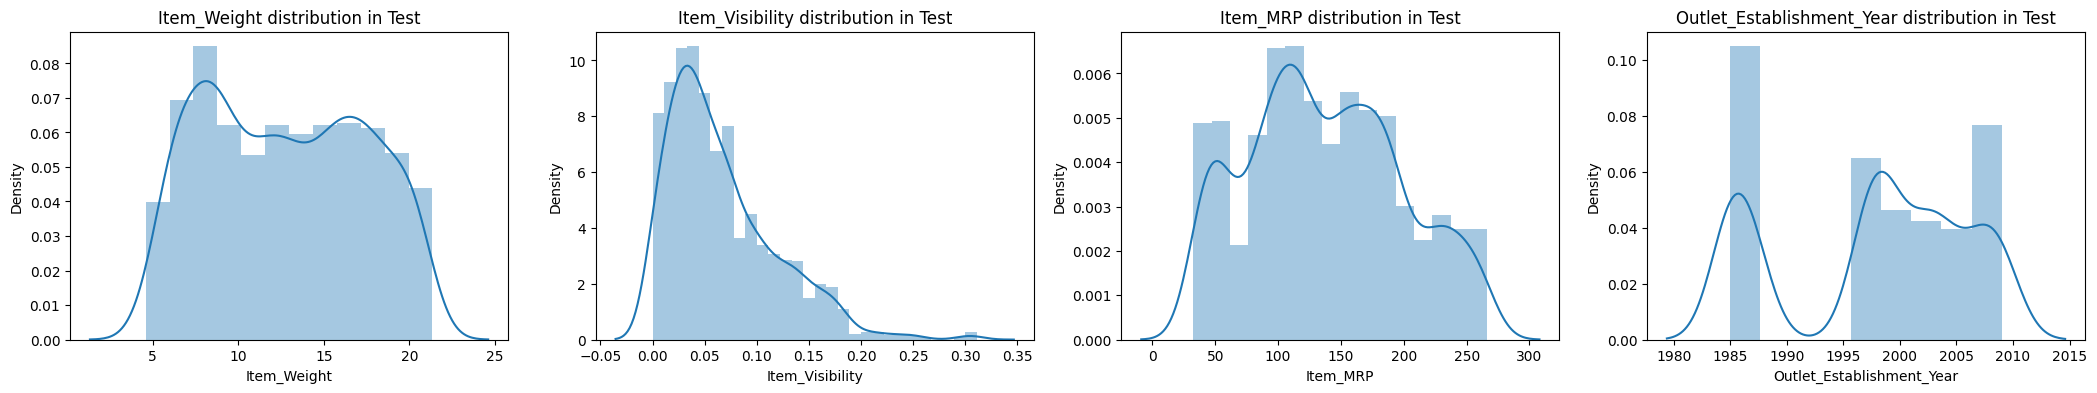

In [94]:
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']):
    sns.distplot(test_subset[col], kde=True, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Test')

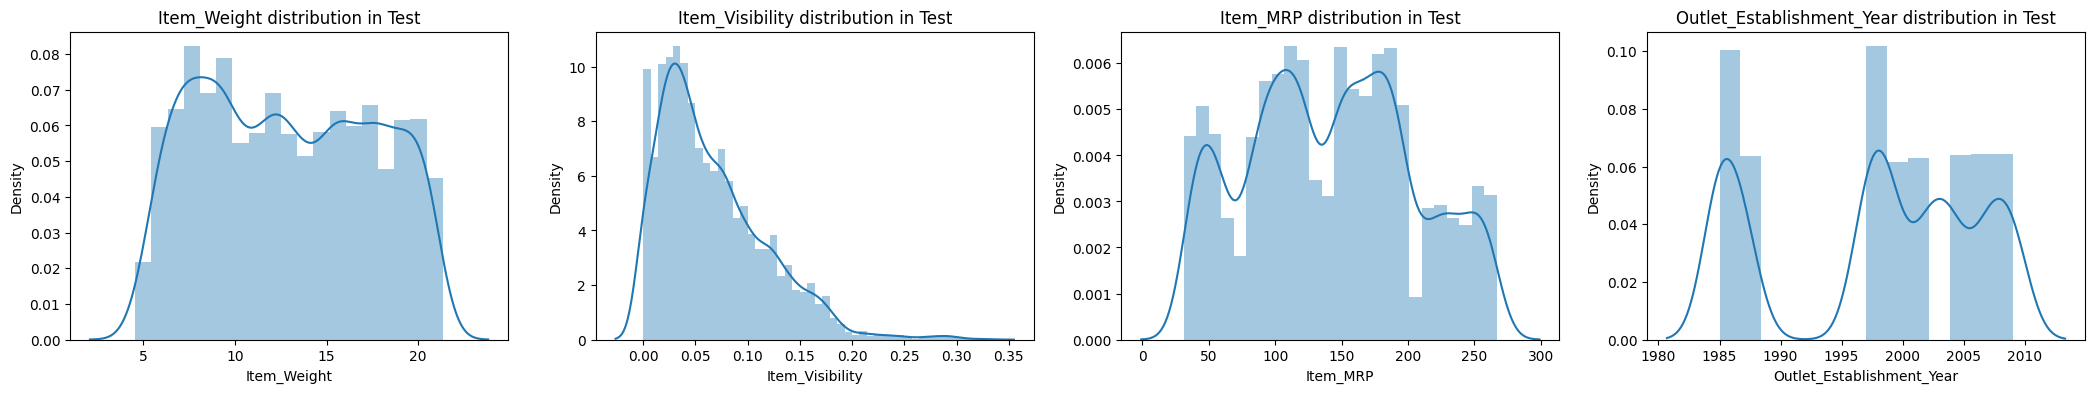

In [95]:
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']):
    sns.distplot(train_subset[col], kde=True, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Test')

Main Observation: Train and Test data have almost the same distribution.

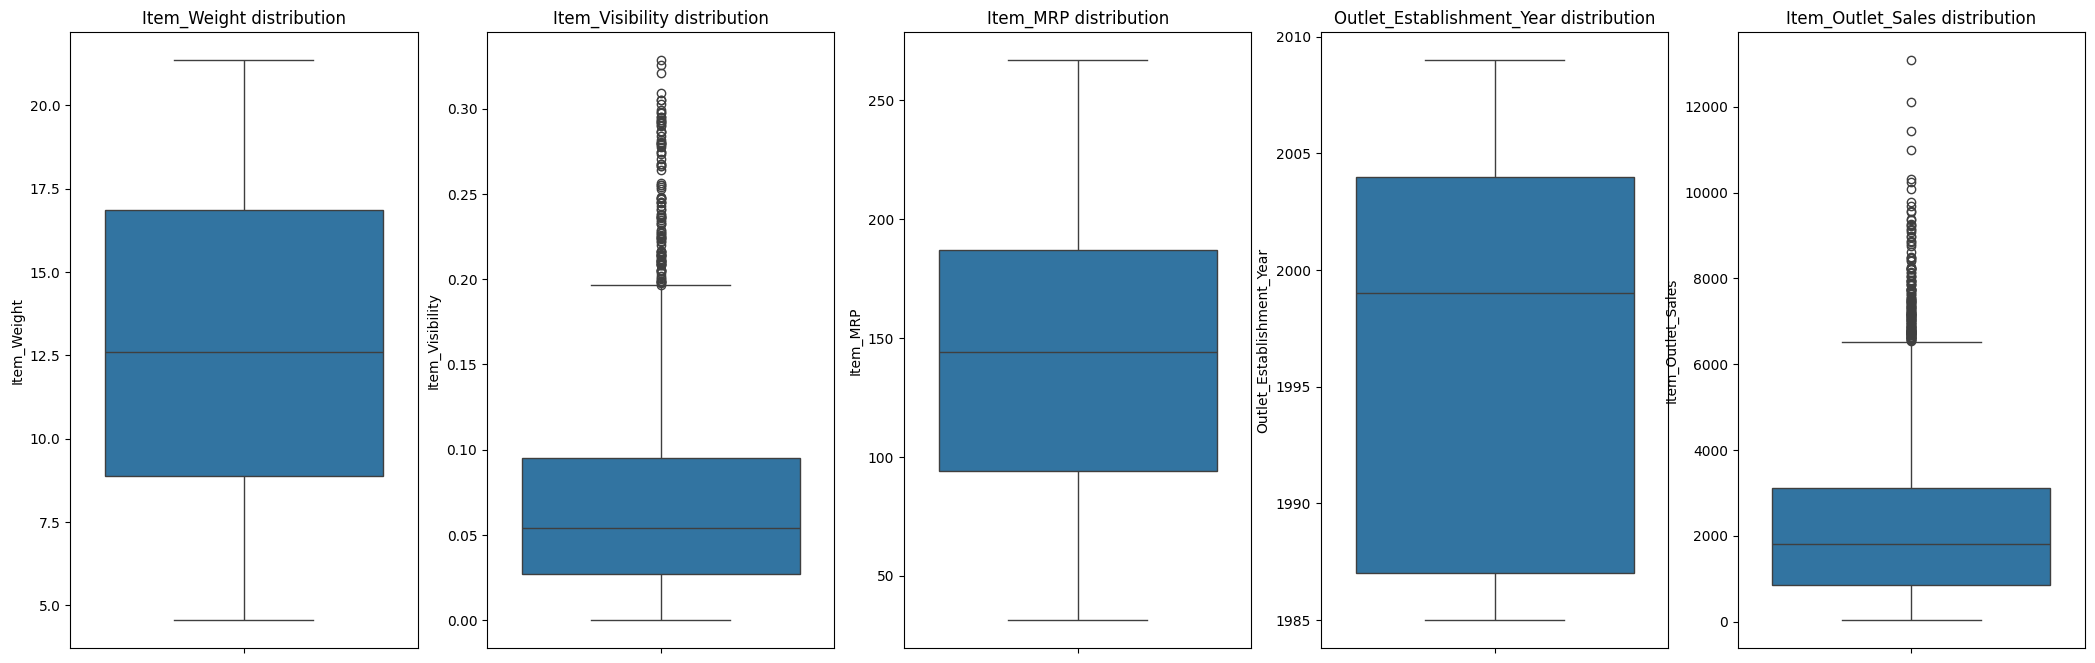

In [96]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))
for index, col in enumerate(numeric_columns):
    sns.boxplot(data=train_subset, y=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

Observations:

- There are no outliers in the Item_Weight, Item_MRP and Outlet_Establishment_Year features.
- But, there are some outliers to be removed in the Item_Visibility and Item_Outlet_Sales features.


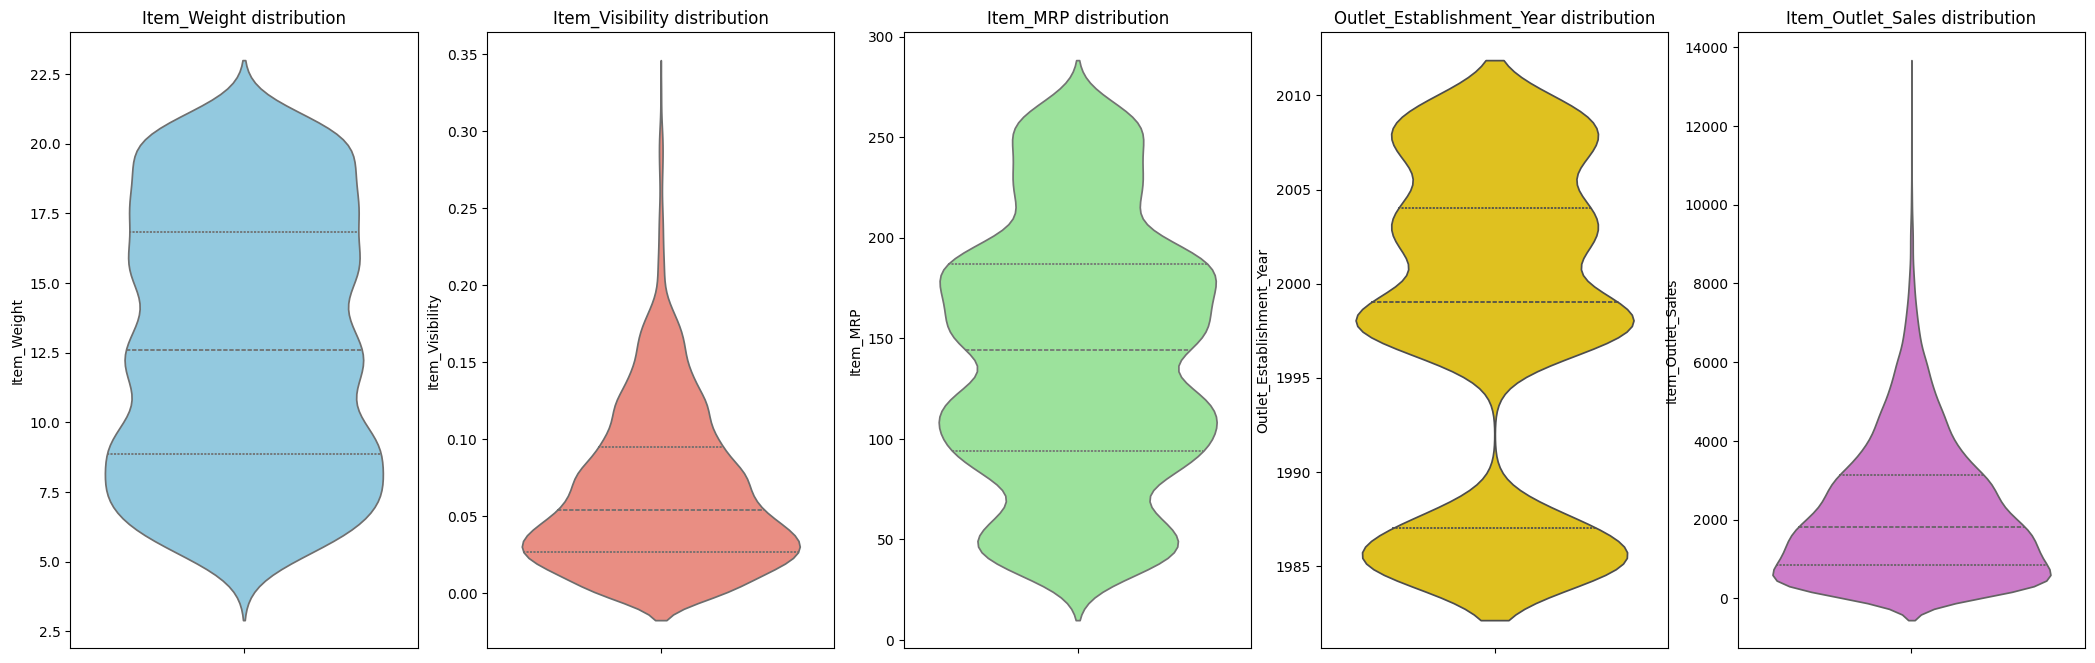

In [97]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'orchid']
for index, col in enumerate(numeric_columns):
    sns.violinplot(data=train_subset, y=col, ax=ax[index], inner='quartile', color=colors[index])
    ax[index].set_title(f'{col} distribution')

Main Observation: Item Visibility and Item Outlet Sales have soome outliers to be filtered.

### 3.1.2 Categorical Features

In [98]:
categorical_columns = train_subset.select_dtypes(include=['object']).columns.tolist()
categorical_columns

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [99]:
categorical_cols_to_display = [
                                 'Item_Fat_Content',
                                 'Item_Type',
                                 'Outlet_Size',
                                 'Outlet_Location_Type',
                                 'Outlet_Type'
                                ]
for col in categorical_cols_to_display:
    print(f"Number of values in the {col} column is:\n{train_subset[col].value_counts() }")
    print("--" * 30)

Number of values in the Item_Fat_Content column is:
Item_Fat_Content
Low Fat    4035
Regular    2336
LF          267
reg          93
low fat      87
Name: count, dtype: int64
------------------------------------------------------------
Number of values in the Item_Type column is:
Item_Type
Fruits and Vegetables    1002
Snack Foods               971
Household                 744
Frozen Foods              681
Dairy                     536
Canned                    513
Baking Goods              509
Health and Hygiene        409
Soft Drinks               354
Meat                      325
Breads                    190
Hard Drinks               183
Others                    139
Starchy Foods             128
Breakfast                  86
Seafood                    48
Name: count, dtype: int64
------------------------------------------------------------
Number of values in the Outlet_Size column is:
Outlet_Size
Medium    2233
Small     1906
High       744
Name: count, dtype: int64
------------

In [100]:
train_subset['Outlet_Location_Type'].unique().tolist()

['Tier 1', 'Tier 2', 'Tier 3']

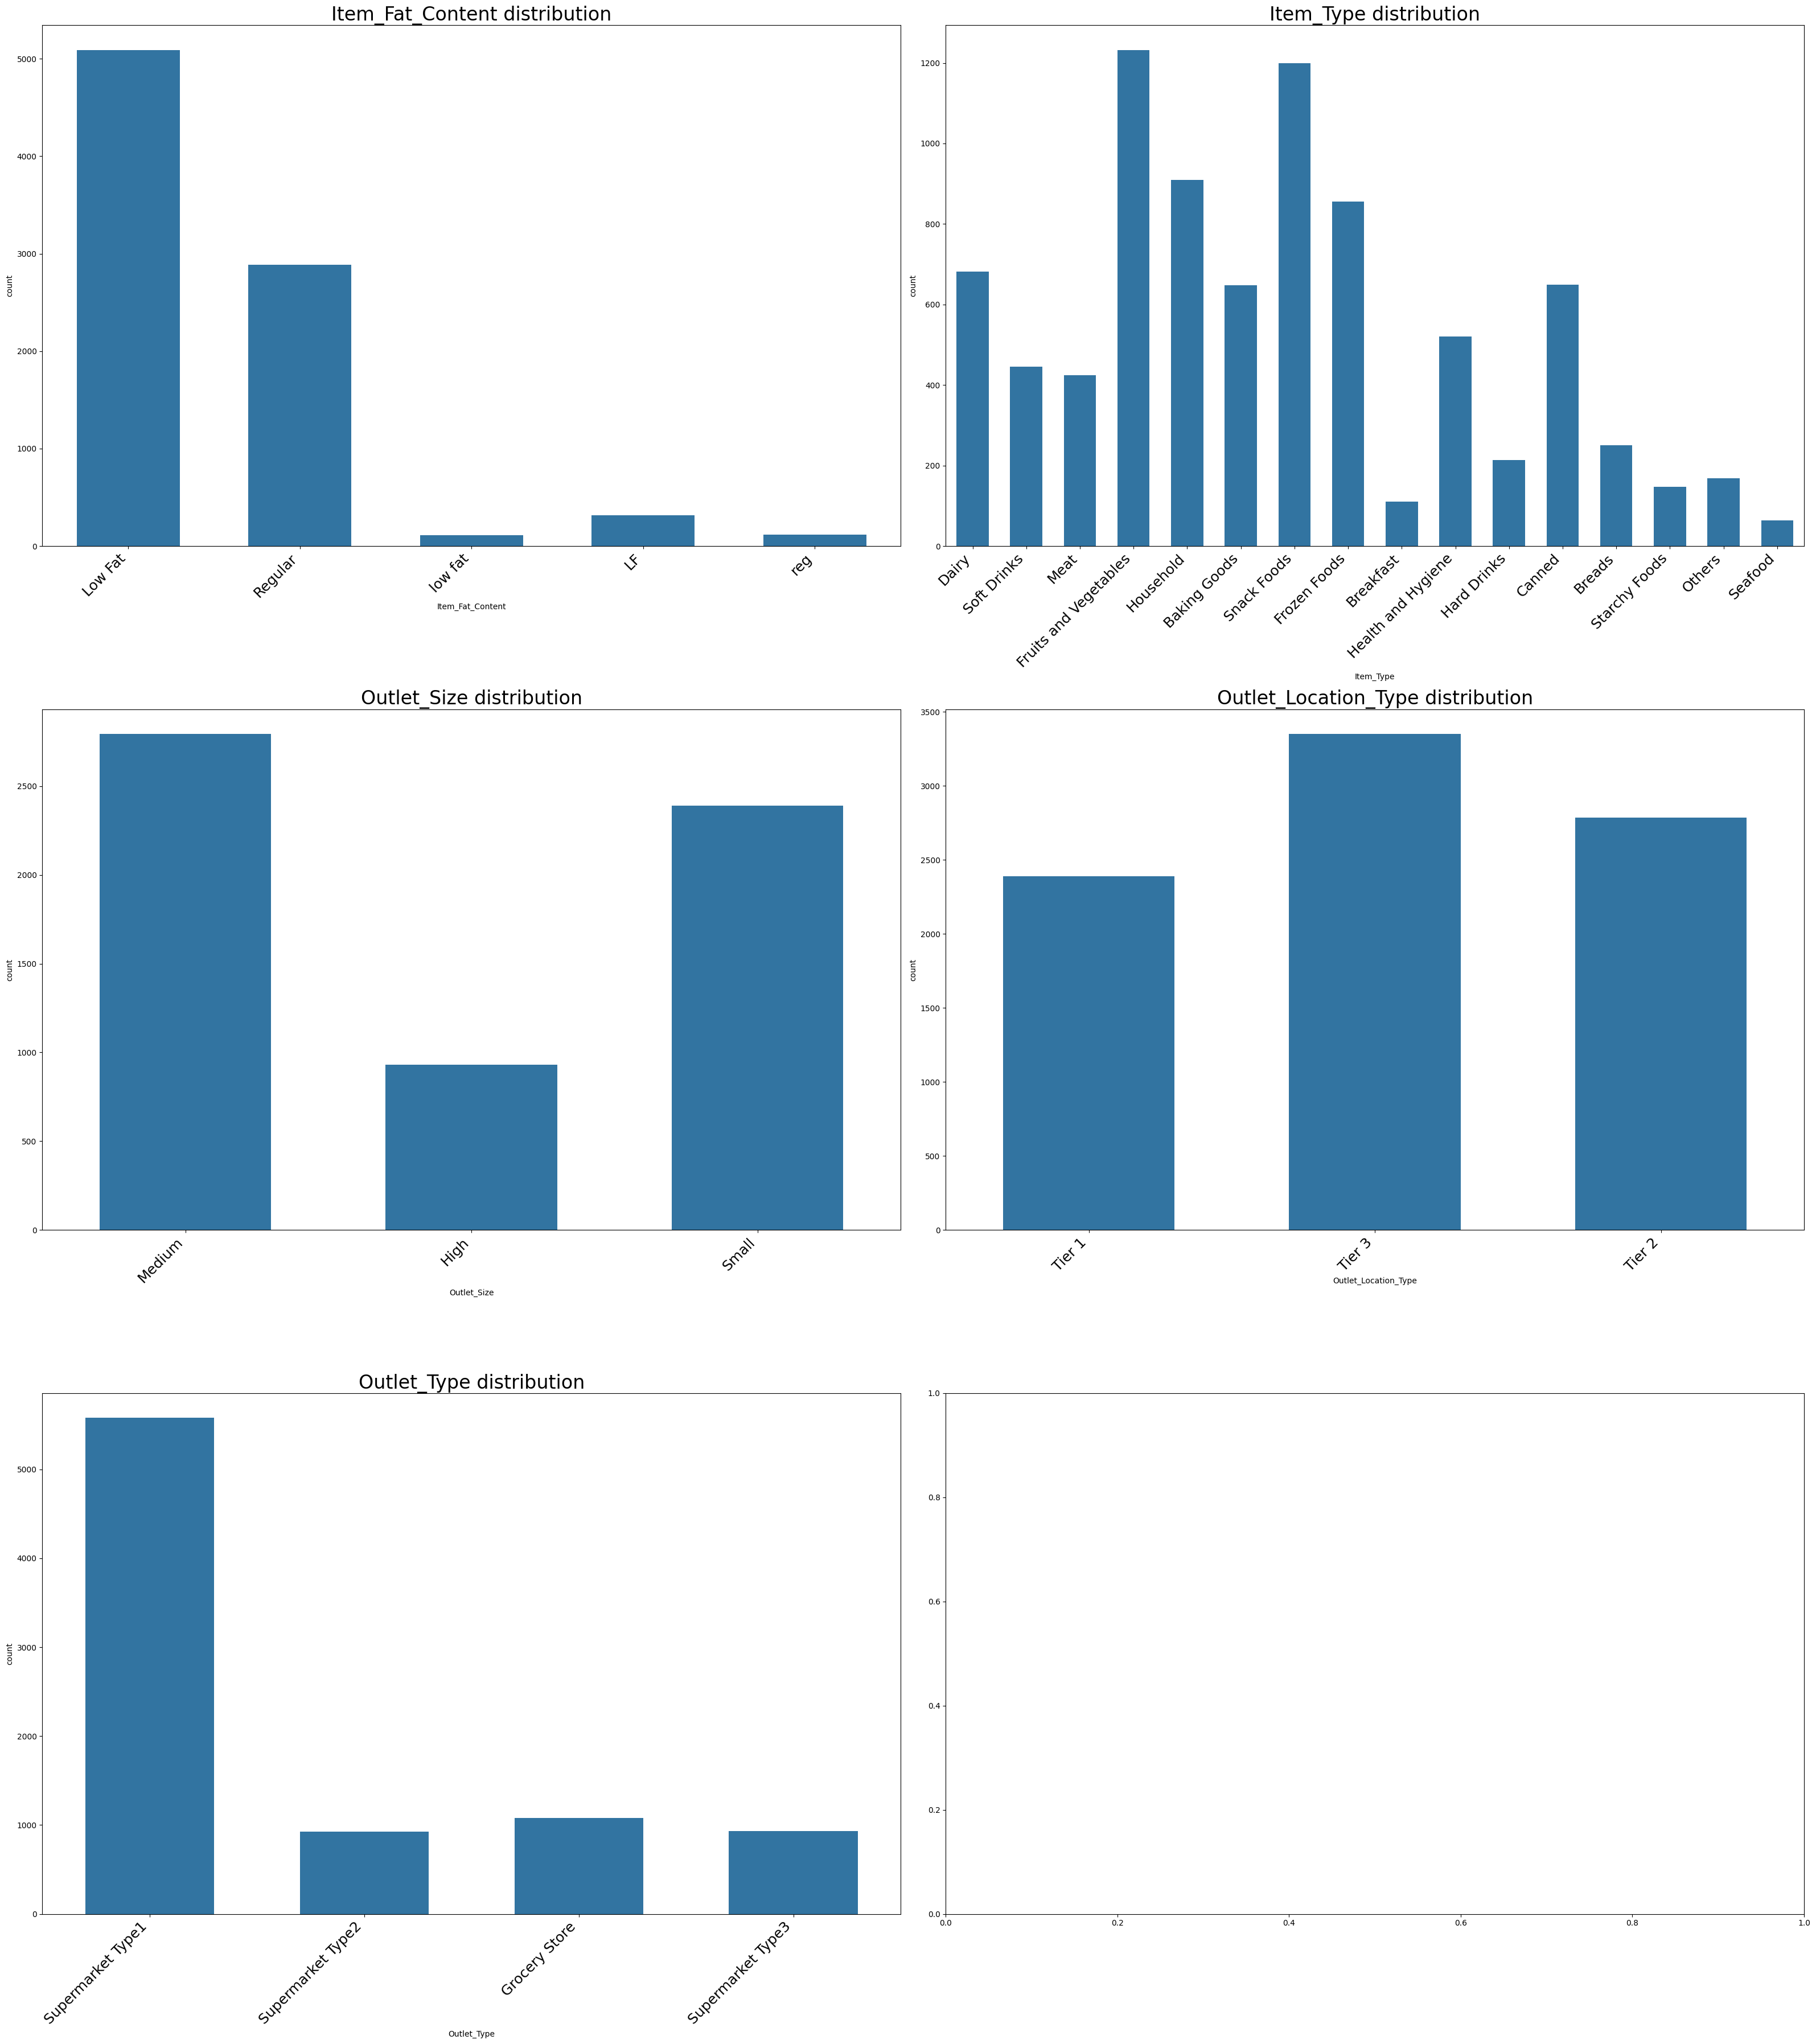

In [103]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(32, 36))

for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    g = sns.countplot(data=train, x=col , ax=ax[r][c], width=0.6)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

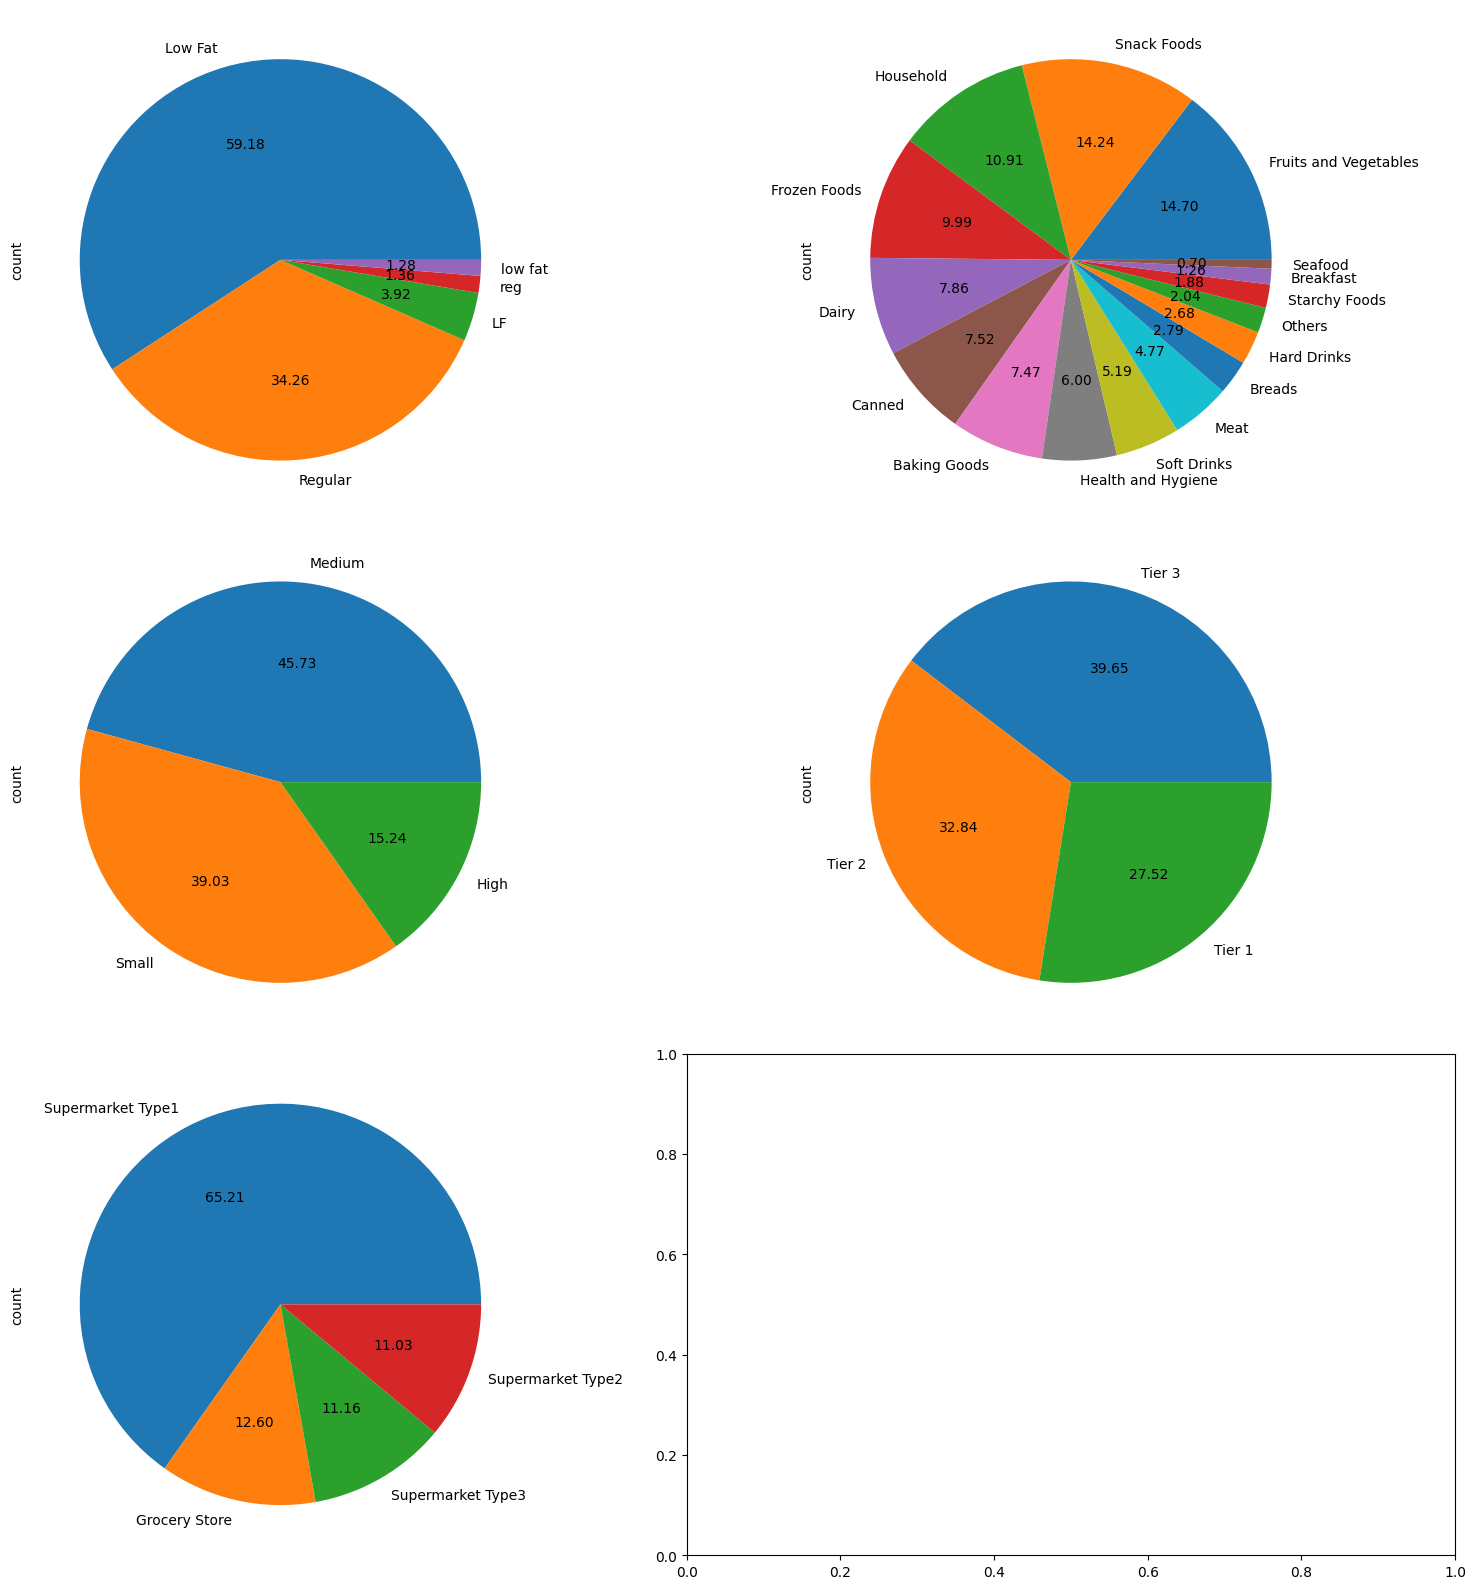

In [104]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))

for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    train_subset[col].value_counts().plot(kind="pie", autopct="%.2f", ax=ax[r][c])
    #g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    #ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

Observations:
- 'Low Fat', 'low fat' and 'LF' should be the same category
- Similarly 'Regular' and 'reg' should also be the same.
- There are 16 different categories in the the Item_type feature.
- This is a lot. So, we can try to group them into categories during feature engineering. Example:
  - 'Soft Drinks' and 'Hard Drinks' into a 'Drinks' category or
'Snack Foods', 'Frozen Foods', 'Snarchy Foods' and 'Seafood' into a 'Foods' category.
- We will encode the Outlet_Location_Type feature, as below:

  - 'Tier 1' ---> 1
  - 'Tier 2' ---> 2
  - 'Tier 3' ---> 3

## 3.2 Bi-variate Analysis

### 3.2.1 Numerical-Numerical

In [105]:
target = "Item_Outlet_Sales"

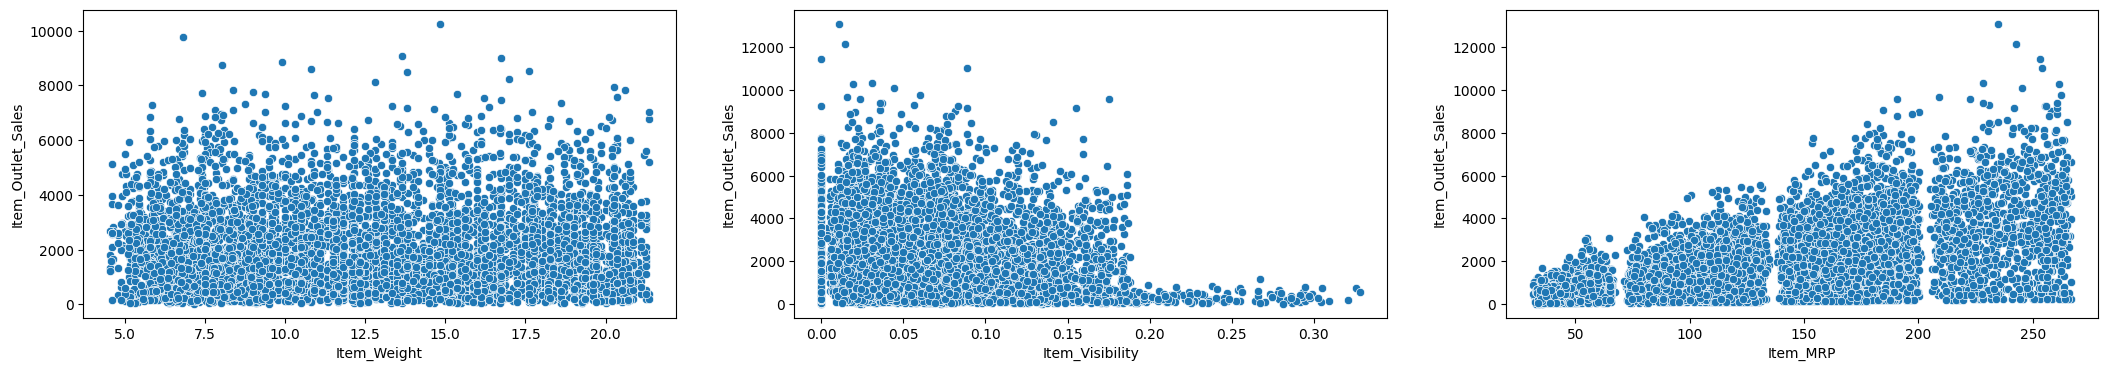

In [106]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=train_subset,x=col, y=target, ax=ax[index])
    #ax[index].set_title(f'{col} distribution')

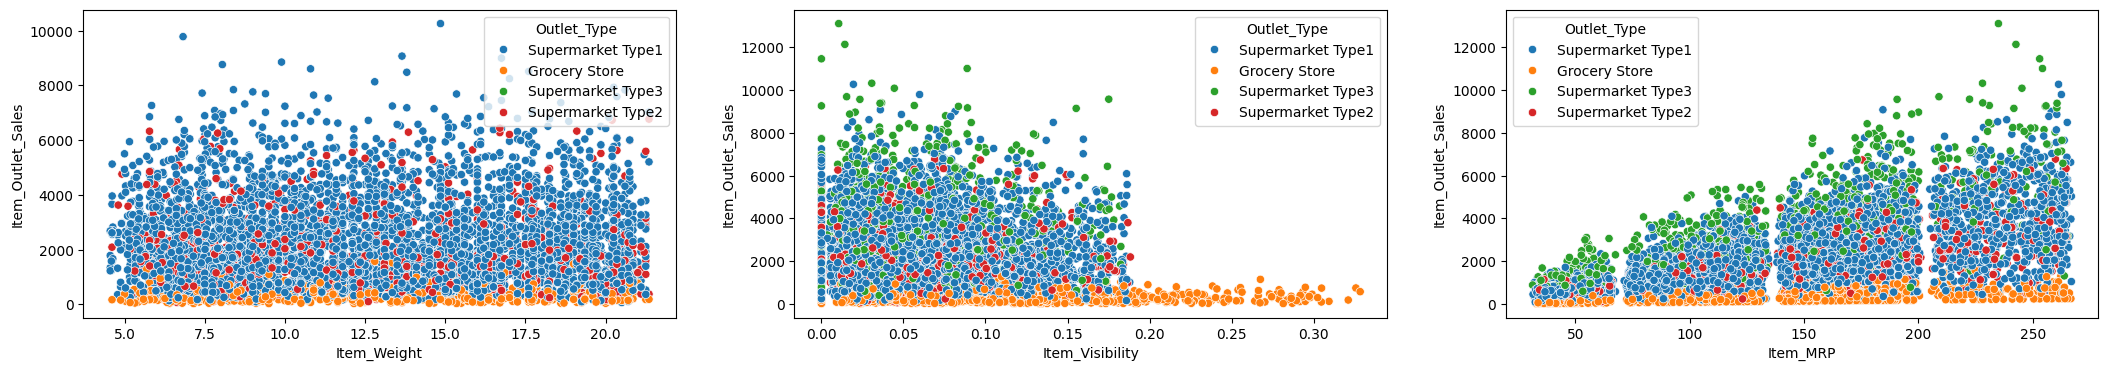

In [107]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=train_subset,x=col, y=target, ax=ax[index], hue='Outlet_Type')

In [108]:
train_subset.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
549,FDW44,9.500,Regular,0.035206,Fruits and Vegetables,171.3448,OUT049,1999,Medium,Tier 1,Supermarket Type1,2386.2272
7757,NCF54,18.000,Low Fat,0.047473,Household,170.5422,OUT045,2002,NaN,Tier 2,Supermarket Type1,3103.9596
764,FDY03,17.600,Regular,0.076122,Meat,111.7202,OUT046,1997,Small,Tier 1,Supermarket Type1,1125.2020
6867,FDQ20,8.325,Low Fat,0.029845,Fruits and Vegetables,41.6138,OUT045,2002,NaN,Tier 2,Supermarket Type1,284.2966
2716,FDP34,12.850,Low Fat,0.137228,Snack Foods,155.5630,OUT046,1997,Small,Tier 1,Supermarket Type1,4224.5010


<Axes: >

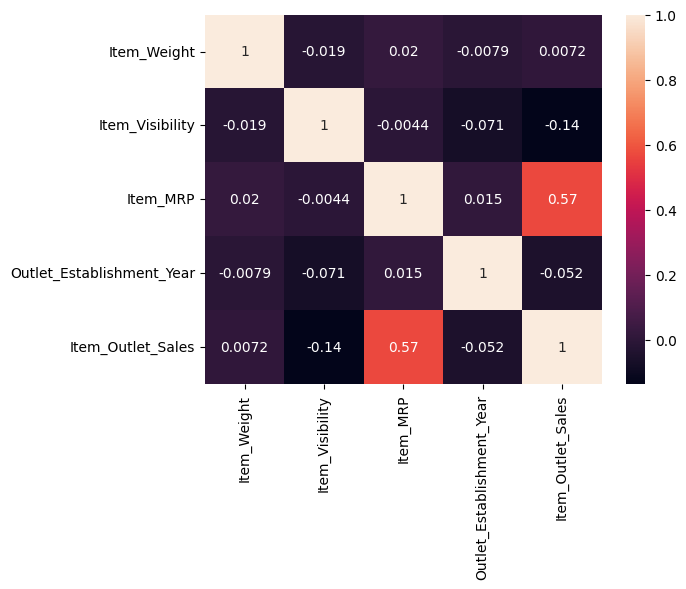

In [109]:
sns.heatmap(train_subset.select_dtypes(include=['float64', 'int64']).corr(), annot=True)

Observation:
- There is a correlation of 0.57 (which is the highest among all the other numeric features) between Item_MRP and Item_Outlet_Sales(target) which indicates a moderate positive relationship, meaning that, in general, as the Item MRP (the price of the item) increases, the Item Outlet Sales (the sales of the item) also tend to increase.

### 3.2.2 Numerical-Categorical

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

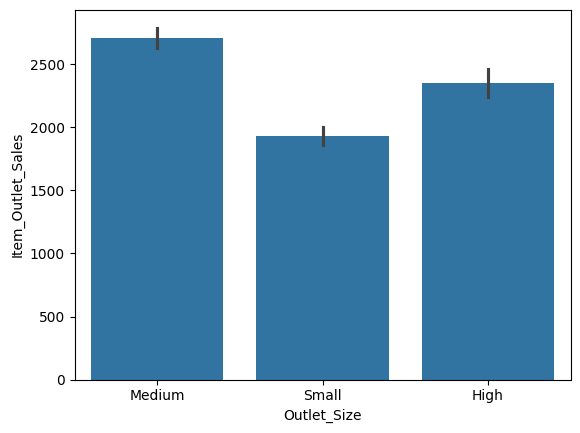

In [110]:
sns.barplot(data=train_subset, x='Outlet_Size', y=target)

In [111]:
train_subset.Outlet_Establishment_Year

,Outlet_Establishment_Year
549,1999
7757,2002
764,1997
6867,2002
2716,1997
...,...
5734,1998
5191,2007
5390,2002
860,2007


# 4. Handling Missing Values

What we have observed till now is that Outlet_Size is a categorical feature.  So, we will be using mode to fill in the missing values.

On the other hand, item weight is a numeric column, and also there are no any outliers as we can clearly see in the plot. So, we will be using mean to replace the missing values.

In [112]:
#filling the object values with mode and float type with mean

# for train
train_subset['Outlet_Size'] = train_subset.Outlet_Size.fillna(train_subset.Outlet_Size.dropna().mode()[0]) #replace by the median after
train_subset['Item_Weight'] = train_subset.Item_Weight.fillna(train_subset.Item_Weight.mean())

# for test
test_subset['Outlet_Size'] = test_subset.Outlet_Size.fillna(test_subset.Outlet_Size.dropna().mode()[0]) #replace by the median after
test_subset['Item_Weight'] = test_subset.Item_Weight.fillna(test_subset.Item_Weight.mean())

In [114]:
train_subset.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


Here, now, we have handled all the missing values.

# 5. Feature Engineering

Upper limit:  0.196568368625
Lower limit:  -0.07483885437499999


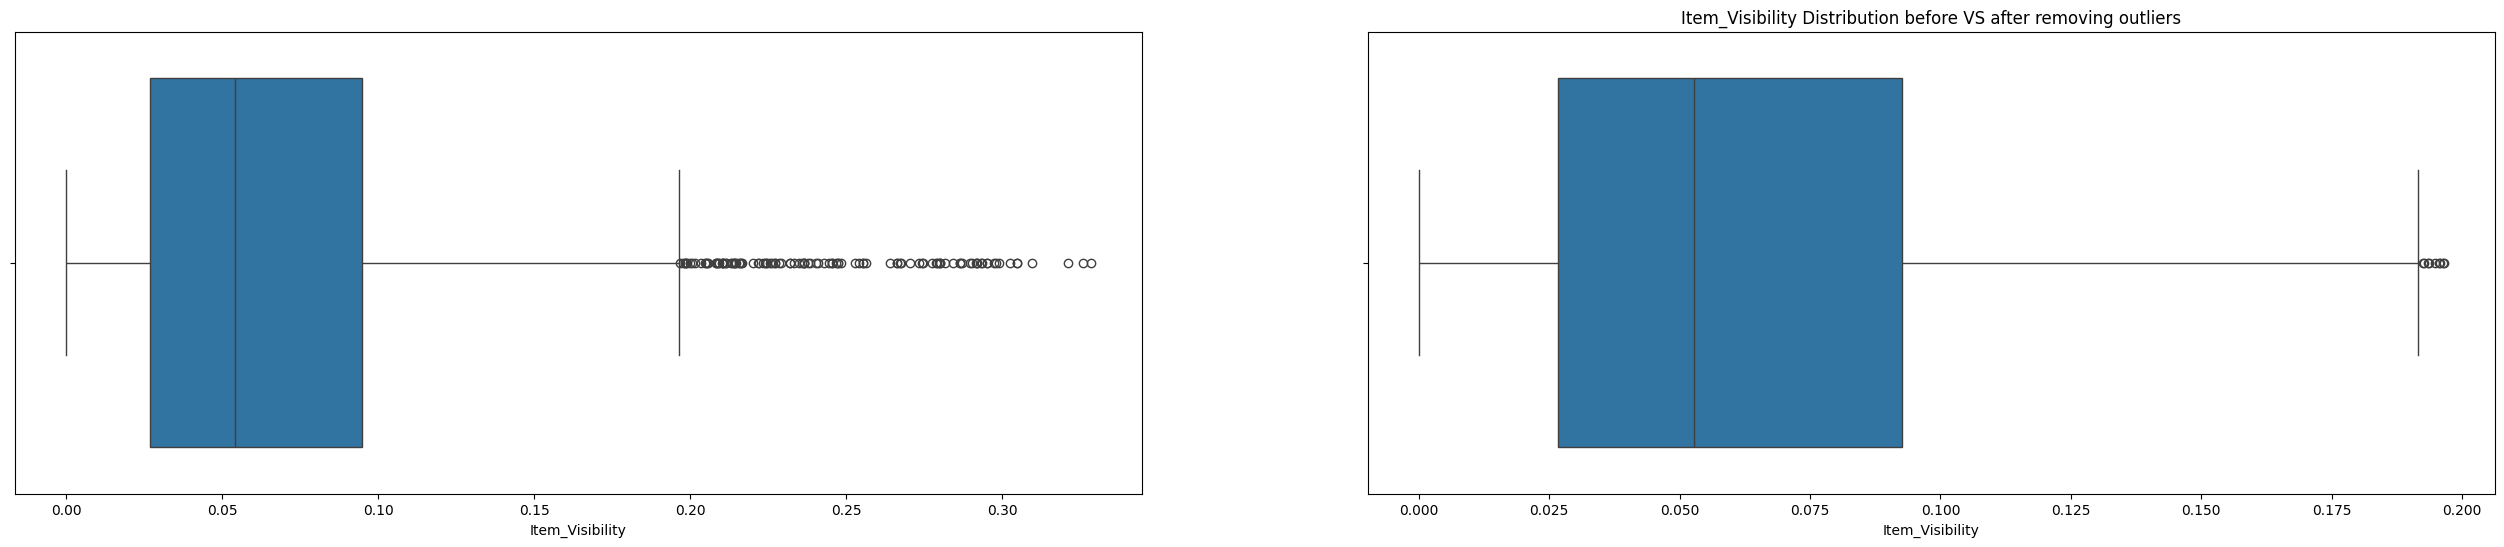

In [115]:
# The function below detects outliers using the IQR method.
# This means it will remove all the data having vales greater than upper limit or less than lower limit.
def detect_outliers(df, feature):
    Q1  = df[feature].quantile(0.25)
    Q3  = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

upper, lower = detect_outliers(train_subset, "Item_Visibility")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=train_subset['Item_Visibility'], ax=ax[0])

# removing outliers using the above function
train_subset = train_subset[(train_subset['Item_Visibility'] > lower) & (train_subset['Item_Visibility'] < upper)] #train
test_subset = test_subset[(test_subset['Item_Visibility'] > lower) & (test_subset['Item_Visibility'] < upper)]     #test

sns.boxplot(x=train_subset['Item_Visibility'], ax=ax[1])
plt.title('Item_Visibility Distribution before VS after removing outliers')
plt.show()

Upper limit:  6334.5876499999995
Lower limit:  -2407.3663500000002


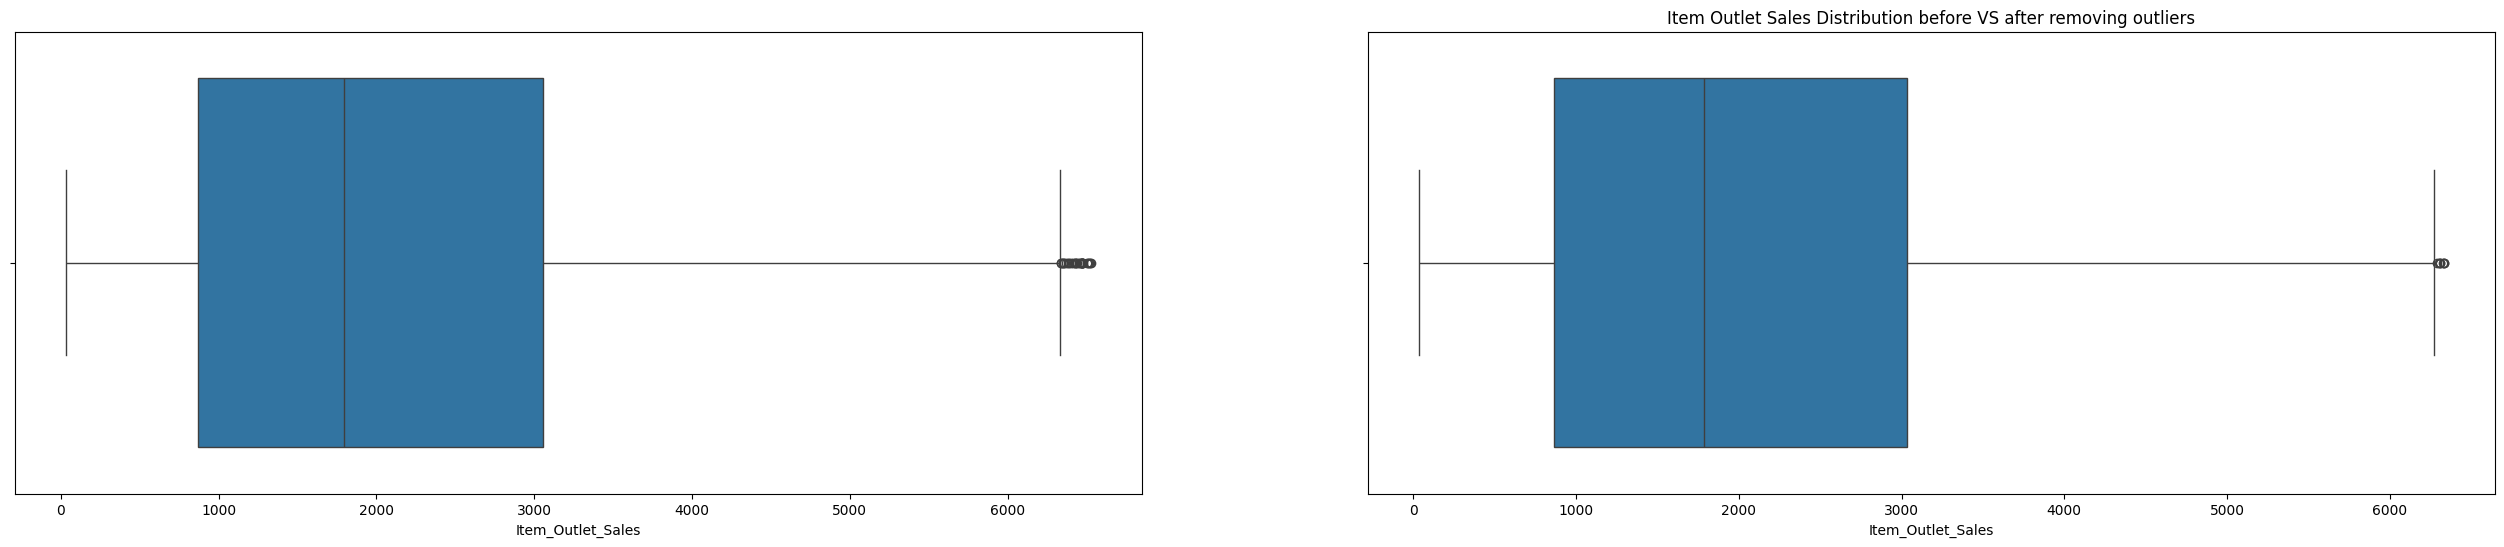

In [117]:
# detect outliers in the Item_Outlet_Sales feature
upper, lower = detect_outliers(train_subset, "Item_Outlet_Sales")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=train_subset['Item_Outlet_Sales'], ax=ax[0])

# removing outliers using the same function
train_subset = train_subset[(train_subset['Item_Outlet_Sales'] > lower) & (train_subset['Item_Outlet_Sales'] < upper)]

sns.boxplot(x=train_subset['Item_Outlet_Sales'], ax=ax[1])
plt.title('Item Outlet Sales Distribution before VS after removing outliers')
plt.show()

Now, we will be correcting the labels in item fat content as well. i.e. replacing LF by Low fat and so on.

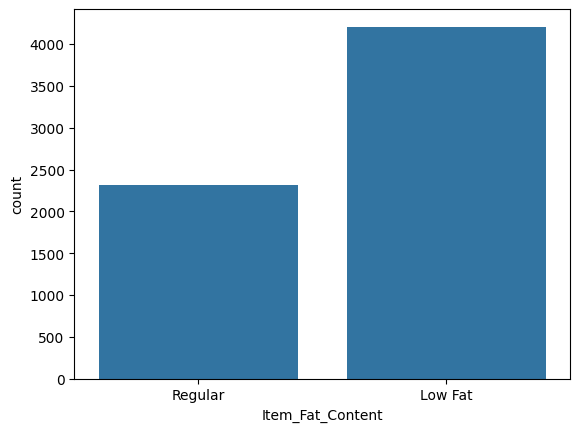

In [118]:
# Let's correct the errors in the Item_Fat_Content column

train_subset['Item_Fat_Content'] = train_subset['Item_Fat_Content'].map({'Low Fat' :'Low Fat',
                                                           'low fat' :"Low Fat",
                                                           'LF'      :"Low Fat",
                                                           'Regular' :'Regular',
                                                           'reg'     :"Regular"
                                                          })

test_subset['Item_Fat_Content'] = test_subset['Item_Fat_Content'].map({'Low Fat' :'Low Fat',
                                                           'low fat' :"Low Fat",
                                                           'LF'      :"Low Fat",
                                                           'Regular' :'Regular',
                                                           'reg'     :"Regular"
                                                          })

sns.countplot(x=train_subset['Item_Fat_Content']);


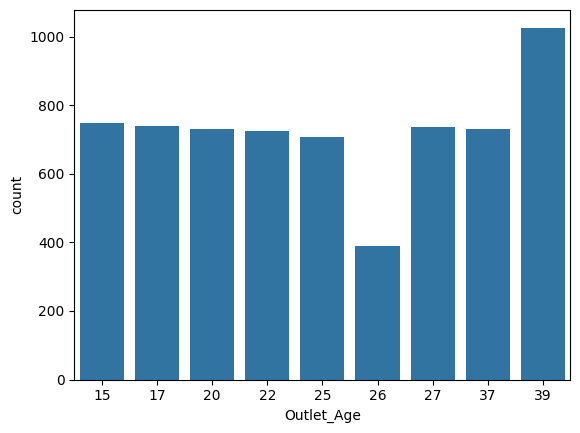

In [119]:
# getting the amount of established years in new column and deleting old column
train_subset['Outlet_Age'] = 2024 - train['Outlet_Establishment_Year']
test_subset['Outlet_Age'] = 2024 - test_subset['Outlet_Establishment_Year']

del train_subset['Outlet_Establishment_Year']
del test_subset['Outlet_Establishment_Year']

sns.countplot(x=train_subset['Outlet_Age']);

## 5.1 Encoding Categorical values

### 5.1.1 Label Encoding

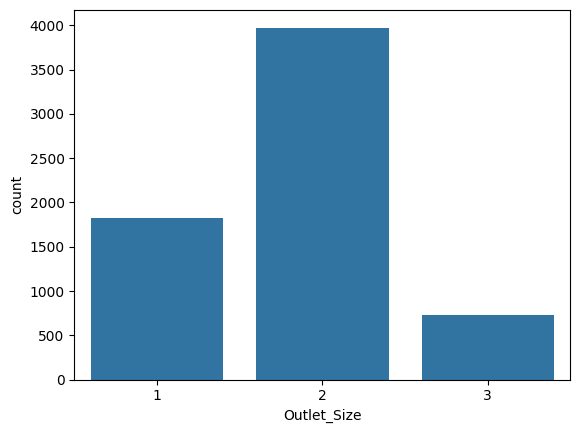

In [120]:
train_subset['Outlet_Size'] = train_subset['Outlet_Size'].map({'Small'  : 1,
                                                 'Medium' : 2,
                                                 'High'   : 3
                                                 }).astype(int)

test_subset['Outlet_Size'] = test_subset['Outlet_Size'].map({'Small'  : 1,
                                               'Medium' : 2,
                                               'High'   : 3
                                              }).astype(int)

sns.countplot(x=train_subset['Outlet_Size']);

<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

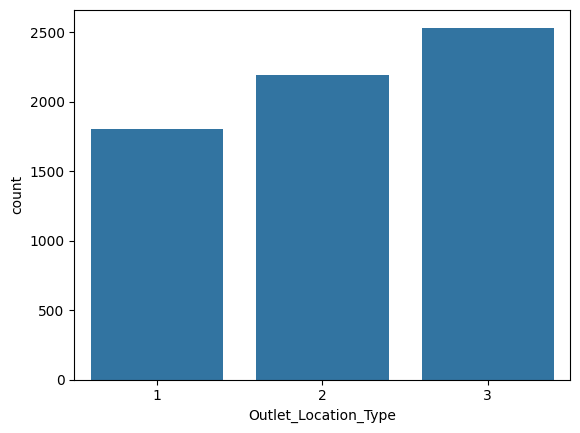

In [121]:
# Outlet_Location_Type feature encoding by getting the last character and converting to int type

train_subset['Outlet_Location_Type'] = train_subset['Outlet_Location_Type'].str[-1:].astype(int)
test_subset['Outlet_Location_Type']  = test_subset['Outlet_Location_Type'].str[-1:].astype(int)
sns.countplot(x=train_subset['Outlet_Location_Type'])

In [122]:
train_subset.Item_Type

,Item_Type
549,Fruits and Vegetables
7757,Household
764,Meat
6867,Fruits and Vegetables
2716,Snack Foods
...,...
6265,Health and Hygiene
5191,Frozen Foods
5390,Health and Hygiene
860,Snack Foods


- In the Item_Type feature, there are 16 categories but when we look closely to Item_Identifier_Categories, it has first two characters defining the item type, these are:

  - FD for probably Food;
  - DR for probably Drinks;
  - NC for probably Non-Consumables.
  - So we'll drop the Item_Identifier feature and create a new column containing these categories.

<Axes: xlabel='Item_Identifier_Categories', ylabel='count'>

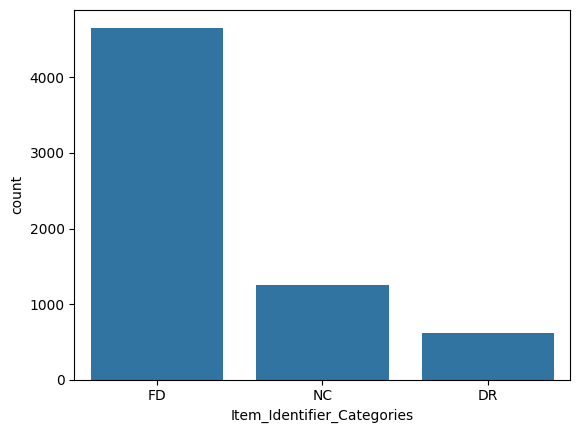

In [123]:
train_subset['Item_Identifier_Categories'] = train_subset['Item_Identifier'].str[0:2]
test_subset['Item_Identifier_Categories']  = test_subset['Item_Identifier'].str[0:2]

sns.countplot(x=train_subset['Item_Identifier_Categories'])

In [124]:
train_subset.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
549,FDW44,9.500,Regular,0.035206,Fruits and Vegetables,171.3448,OUT049,2,1,Supermarket Type1,2386.2272,25,FD
7757,NCF54,18.000,Low Fat,0.047473,Household,170.5422,OUT045,2,2,Supermarket Type1,3103.9596,22,NC
764,FDY03,17.600,Regular,0.076122,Meat,111.7202,OUT046,1,1,Supermarket Type1,1125.2020,27,FD
6867,FDQ20,8.325,Low Fat,0.029845,Fruits and Vegetables,41.6138,OUT045,2,2,Supermarket Type1,284.2966,22,FD
2716,FDP34,12.850,Low Fat,0.137228,Snack Foods,155.5630,OUT046,1,1,Supermarket Type1,4224.5010,27,FD


In [125]:
#Label Encoder for Ordinate Data

encoder = LabelEncoder()
ordinal_features = ['Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type']

for feature in ordinal_features:
    train_subset[feature] = encoder.fit_transform(train_subset[feature])
    test_subset[feature]  = encoder.fit_transform(test_subset[feature])

train_subset.shape

(6528, 13)

In [126]:
train_subset.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
549,FDW44,9.500,1,0.035206,Fruits and Vegetables,171.3448,OUT049,2,0,1,2386.2272,25,FD
7757,NCF54,18.000,0,0.047473,Household,170.5422,OUT045,2,1,1,3103.9596,22,NC
764,FDY03,17.600,1,0.076122,Meat,111.7202,OUT046,1,0,1,1125.2020,27,FD
6867,FDQ20,8.325,0,0.029845,Fruits and Vegetables,41.6138,OUT045,2,1,1,284.2966,22,FD
2716,FDP34,12.850,0,0.137228,Snack Foods,155.5630,OUT046,1,0,1,4224.5010,27,FD


In [127]:
test_subset.shape

(1675, 13)

### 5.1.2 One Hot Encoding

In [128]:
# One Hot Encoding for 'Item_Type' variable

train_subset = pd.get_dummies(train_subset, columns=['Item_Type', 'Item_Identifier_Categories', 'Outlet_Identifier'], drop_first=True)
test_subset  = pd.get_dummies(test_subset,  columns=['Item_Type', 'Item_Identifier_Categories', 'Outlet_Identifier'], drop_first=True)

In [129]:
train_subset.head()
train_subset.shape

(6528, 36)

### 5.1.3 Final Data Preprocessing

In [130]:
# Dropping Useless Columns
train_subset.drop(labels=['Item_Identifier'], axis=1, inplace=True)
test_subset.drop(labels=['Item_Identifier'],  axis=1, inplace=True)

In [131]:
X_train = train_subset.drop('Item_Outlet_Sales', axis=1)
y_train = train_subset['Item_Outlet_Sales']

In [132]:
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,...,Item_Identifier_Categories_NC,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
549,9.500,1,0.035206,171.3448,2,0,1,25,False,False,...,False,False,False,False,False,False,False,False,False,True
7757,18.000,0,0.047473,170.5422,2,1,1,22,False,False,...,True,False,False,False,False,False,False,True,False,False
764,17.600,1,0.076122,111.7202,1,0,1,27,False,False,...,False,False,False,False,False,False,False,False,True,False
6867,8.325,0,0.029845,41.6138,2,1,1,22,False,False,...,False,False,False,False,False,False,False,True,False,False
2716,12.850,0,0.137228,155.5630,1,0,1,27,False,False,...,False,False,False,False,False,False,False,False,True,False


In [133]:
y_train.head()

,Item_Outlet_Sales
549,2386.2272
7757,3103.9596
764,1125.2020
6867,284.2966
2716,4224.5010


In [134]:
X_test = test_subset.drop('Item_Outlet_Sales', axis=1)
y_test = test_subset['Item_Outlet_Sales']

# 6. Training Models

## 6.1 Linear Regression

In [135]:
X_train.dtypes

,0
Item_Weight,float64
Item_Fat_Content,int64
Item_Visibility,float64
Item_MRP,float64
Outlet_Size,int64
Outlet_Location_Type,int64
Outlet_Type,int64
Outlet_Age,int64
Item_Type_Breads,bool
Item_Type_Breakfast,bool


In [136]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [137]:
# Predictions for LinearRegression on the test data
lin_reg_predictions = lin_reg_model.predict(X_test)

In [138]:
print('Training score  : {}'.format(lin_reg_model.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_model.score(X_test, y_test)))

Training score  : 0.5451239797956746
Test score      : 0.5641587758774469


In [139]:
# Evaluation
lin_reg_mse  = mean_squared_error(y_test , lin_reg_predictions)
lin_reg_rmse = math.sqrt(lin_reg_mse)
lin_reg_r2   = r2_score(y_test, lin_reg_predictions)

print('RMSE  \t         ----> {}'.format(lin_reg_rmse))
print('R2 Score         ----> {}'.format(lin_reg_r2))

RMSE  	         ----> 1086.9719384779219
R2 Score         ----> 0.5641587758774469


- Here, our LinearRegression model above give us a training accuracy of 54.51% and a test accuracy of about 56.41%. We also get an RMSE of about 1021.52 and a R2 score of 0.54.
- Now, we will try to add some polynomial features to see how good the Linear Regression performs.
- Also, standardizing our data so that our data scales down to a range between 0 and 1. This serves the purpose of letting us work with reasonable numbers when we raise to a power.

In [149]:
steps = [
    ('scaler', StandardScaler()),
    ('poly',   PolynomialFeatures(degree=2)),
    ('model',  LinearRegression())
       ]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, y_train)

print('Training score  : {}'.format(lin_reg_pipeline.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_pipeline.score(X_test, y_test)))

Training score  : 0.5937315477508008
Test score      : -5.018516761846568e+18


The training score increased to 59.37%, but the test score decreased significantly, which suggests model overfitting.

So, we will try to use regularized linear regression.

### 6.1.1 Ridge Regression or l2 Regularization

In [151]:
steps = [
            ('scaler', StandardScaler()),
            ('poly'  , PolynomialFeatures(degree=2)),
            ('model' , Ridge(alpha=7, fit_intercept=True))
       ]

ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(X_train, y_train)

print('Training Score  : {}'.format(ridge_pipeline.score(X_train, y_train)))
print('Test Score      : {}'.format(ridge_pipeline.score(X_test, y_test)))

Training Score  : 0.5937358507577543
Test Score      : 0.5894360159277973


We got a training score of 59.37% and the test score to 58.94%

In [152]:
# Predictions for Ridge on the test data
ridge_predictions = ridge_pipeline.predict(X_test)


In [153]:
# Evaluation
ridge_mse  = mean_squared_error(y_test , ridge_predictions)
ridge_rmse = math.sqrt(ridge_mse)
ridge_r2   = r2_score(y_test, ridge_predictions)

print('Ridge RMSE  \t         ----> {}'.format(ridge_rmse))
print('Ridge R2 Score         ----> {}'.format(ridge_r2))

Ridge RMSE  	         ----> 1054.9809172413795
Ridge R2 Score         ----> 0.5894360159277973


### 6.1.2 Lasso Regression or L1 Regularization

In [154]:
steps = [
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2)),
            ('model', Lasso(alpha=0.2, fit_intercept=True))
        ]

lasso_pipeline = Pipeline(steps)

lasso_pipeline.fit(X_train, y_train)

print('Training score  : {}'    .format(lasso_pipeline.score(X_train, y_train)))
print('Test score      : {}'    .format(lasso_pipeline.score(X_test, y_test)))

Training score  : 0.5936963664412037
Test score      : 0.5902295100301929


In [155]:
# Predictions for Lasso on the testset
lasso_predictions = lasso_pipeline.predict(X_test)

In [156]:
# Evaluation
lasso_mse  = mean_squared_error(y_test , lasso_predictions)
lasso_rmse = math.sqrt(lasso_mse)
lasso_r2   = r2_score(y_test, lasso_predictions)

print('Lasso RMSE  \t         ----> {}'.format(lasso_rmse))
print('Lasso R2 Score         ----> {}'.format(lasso_r2))

Lasso RMSE  	         ----> 1053.9609471096585
Lasso R2 Score         ----> 0.5902295100301929


## 6.2 Random Forest

In [158]:
rand_forest_model = RandomForestRegressor()
rand_forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [159]:
# Predictions for XGBoost on the test data
rand_forest_predictions = rand_forest_model.predict(X_test)

In [161]:
print('Training score  : {}'.format(rand_forest_model.score(X_train, y_train)))
print('Test score      : {}'.format(rand_forest_model.score(X_test, y_test)))

Training score  : 0.9335383616268568
Test score      : 0.5471580079294512


In [162]:
# Evaluation
rand_forest_mse = mean_squared_error(y_test , rand_forest_predictions)
rand_forest_rmse = math.sqrt(rand_forest_mse)
rand_forest_r2 = r2_score(y_test, rand_forest_predictions)

print('RandomForest RMSE  \t       ----> {}'.format(rand_forest_rmse))
print('RandomForest R2 Score       ----> {}'.format(rand_forest_r2))

RandomForest RMSE  	       ----> 1107.9687863724978
RandomForest R2 Score       ----> 0.5471580079294512


### Hyper Parameter Tuning for Random Forest

In [168]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],   # Max depth of the tree
    'min_samples_split': [2, 5, 10],   # Min samples to split
    'min_samples_leaf': [1, 2, 4],     # Min samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Max features for split
    'bootstrap': [True, False]  # Bootstrap sampling
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rand_forest_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-validation score: {grid_search.best_score_}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


## 6.1.3 XGBoost

In [163]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [164]:
print('XGBoost Training score  : {}'.format(xgb_model.score(X_train, y_train)))
print('XGBoost Test score      : {}'.format(xgb_model.score(X_test, y_test)))

XGBoost Training score  : 0.8439592009518142
XGBoost Test score      : 0.520847910425986


In [166]:
# Predictions for XGBoost on the test data
xgb_predictions = xgb_model.predict(X_test)

In [167]:
# Evaluation
xgb_mse = mean_squared_error(y_test , xgb_predictions)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost RMSE  \t   ----> {}'.format(xgb_rmse))
print('XGBoost R2 Score   ----> {}'.format(xgb_r2))

XGBoost RMSE  	   ----> 1139.7008515447762
XGBoost R2 Score   ----> 0.520847910425986
